In [62]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import approxCountDistinct, countDistinct
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.ml.classification import RandomForestClassifier

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
spark = SparkSession.builder.appName('VariableSelection').getOrCreate()

In [3]:
# printing the spark session info:
spark

In [4]:
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

In [5]:
# File:
file_name = "data/bank-full.csv"

In [6]:
# reading the data:
df = spark.read.csv(file_name, inferSchema=True, header=True, sep=";")

In [7]:
# length of the data:
df.count()

45211

In [8]:
# describing the data:
df.describe().toPandas()

,summary,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,count,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211
1,mean,40.93621021432837,None,None,None,None,1362.2720576850766,None,None,None,15.80641879188693,None,258.1630797814691,2.763840658246887,40.19782796222158,0.5803233726305546,None,None
2,stddev,10.618762040975401,None,None,None,None,3044.7658291685243,None,None,None,8.322476153044589,None,257.5278122651712,3.0980208832791813,100.12874599059818,2.3034410449312164,None,None
3,min,18,admin.,divorced,primary,no,-8019,no,no,cellular,1,apr,0,1,-1,0,failure,no
4,max,95,unknown,single,unknown,yes,102127,yes,yes,unknown,31,sep,4918,63,871,275,unknown,yes


In [9]:
# type of each column
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



##### Cardinality Check

In [10]:
# Note approxCountDistinct and countDistinct can be used interchangeably
# approxCountDistinct is useful for larger dataset
# countDistinct is useful for medium and small datasets

In [11]:
# creating a function to check the cardinality:

def check_cardinality(df, cut_off=1):
    cardinality = df.select(*[approxCountDistinct(c).alias(c) for c in df.columns])
    
    # converting to pandas df, for efficiency
    card_df = cardinality.toPandas().transpose()
    card_df.reset_index(inplace=True)
    card_df.rename(columns={0: 'Cardinality'}, inplace=True)
    
    # selecting features with cardinalty 1:
    vars_selected = card_df['index'][card_df['Cardinality'] <= cut_off]
    
    return card_df, vars_selected

In [12]:
# getting the cardinality df and features with cardinality equal to 1
cardinality_df, cardinality_vars_selected = check_cardinality(df)

In [13]:
# looking at the df:
print(cardinality_df)
print(f"Features with cardinality 1: {cardinality_vars_selected}")

        index  Cardinality
0         age           76
1         job           11
2     marital            3
3   education            4
4     default            2
5     balance         7375
6     housing            2
7        loan            2
8     contact            3
9         day           32
10      month           12
11   duration         1605
12   campaign           47
13      pdays          547
14   previous           42
15   poutcome            4
16          y            2
Features with cardinality 1: Series([], Name: index, dtype: object)


##### Missing Values Check:

In [14]:
def missing_value_check(df, miss_percentage=0.80):
    # checking for missing values:
    missing = df.select(*[count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])
    total_length = df.count()
    
    # converting to pandas df for efficiency:
    missing_df = missing.toPandas().transpose()
    missing_df.reset_index(inplace=True)
    missing_df.rename(columns={0: 'missing_count'}, inplace=True)
    missing_df['percentage_missing'] = missing_df['missing_count'] / total_length
    
    # features with missing values greater than 80%
    vars_selected = missing_df['index'][missing_df['percentage_missing'] >= miss_percentage]
    
    return missing_df, vars_selected

In [15]:
# getting the missing values and features with missing values greater than 80%
missing_df, missing_vars = missing_value_check(df)

In [16]:
print(missing_df)
print(missing_vars)

        index  missing_count  percentage_missing
0         age              0                 0.0
1         job              0                 0.0
2     marital              0                 0.0
3   education              0                 0.0
4     default              0                 0.0
5     balance              0                 0.0
6     housing              0                 0.0
7        loan              0                 0.0
8     contact              0                 0.0
9         day              0                 0.0
10      month              0                 0.0
11   duration              0                 0.0
12   campaign              0                 0.0
13      pdays              0                 0.0
14   previous              0                 0.0
15   poutcome              0                 0.0
16          y              0                 0.0
Series([], Name: index, dtype: object)


*There are no missing values.*

<b><i>In this dataset, there is no need to drop any columns based on Cardinality and Missing Values Check</i></b>

##### Identifying Variable Types:

In [17]:
def variable_type(df):
    
    vars_list = df.dtypes
    char_vars = []
    num_vars = []
    
    for i in vars_list:
        if i[1] in ('string'):
            char_vars.append(i[0])
        else:
            num_vars.append(i[0])
    
    return char_vars, num_vars

In [18]:
char_vars, num_vars = variable_type(df)

In [19]:
print(f"Categorical Variables:\n{char_vars}")
print(f"Numeric Variables:\n{num_vars}")

Categorical Variables:
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']
Numeric Variables:
['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


##### Applying StringIndexer to Char Vars

In [20]:
# converting char to numeric columns:

def cat_to_int(df, char_vars):
    char_df = df.select(char_vars)
    
    indexers = [StringIndexer(inputCol=c, outputCol=c+'_index', handleInvalid='keep') for c in char_df.columns]
    pipeline = Pipeline(stages=indexers)
    
    char_labels = pipeline.fit(char_df)
    df = char_labels.transform(df)
    return df, char_labels

In [21]:
df, char_labels = cat_to_int(df, char_vars)

In [22]:
# Lets select the required columns:

df = df.select(*[c for c in df.columns if c not in char_vars])

In [23]:
df.columns

['age',
 'balance',
 'day',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'job_index',
 'marital_index',
 'education_index',
 'default_index',
 'housing_index',
 'loan_index',
 'contact_index',
 'month_index',
 'poutcome_index',
 'y_index']

In [24]:
# renaming the _index vars to original column names:
def rename_cols(df, char_vars):
    mapping = dict(zip([i + '_index' for i in char_vars], char_vars))
    df = df.select([col(c).alias(mapping.get(c, c)) for c in df.columns])
    
    return df

In [25]:
# applying rename function to the df
df = rename_cols(df, char_vars)

In [26]:
df.columns

['age',
 'balance',
 'day',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome',
 'y']

In [27]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- balance: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- job: double (nullable = false)
 |-- marital: double (nullable = false)
 |-- education: double (nullable = false)
 |-- default: double (nullable = false)
 |-- housing: double (nullable = false)
 |-- loan: double (nullable = false)
 |-- contact: double (nullable = false)
 |-- month: double (nullable = false)
 |-- poutcome: double (nullable = false)
 |-- y: double (nullable = false)



##### Assembling the Features into One Single Feature:

In [28]:
# Assembling all features into one column - 'feature'

def assemble_features(df, features_list, target_variable_name):
    assembler = VectorAssembler(inputCols=features_list, outputCol='feature')
    
    # selecting all the columns:
    selected_cols = [target_variable_name, 'feature'] + features_list
    
    # creating the pipeline:
    pipeline = Pipeline(stages=[assembler])
    assembleModel = pipeline.fit(df)
    
    # applying the model to the data:
    df = assembleModel.transform(df).select(selected_cols)
    return df

In [29]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- balance: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- job: double (nullable = false)
 |-- marital: double (nullable = false)
 |-- education: double (nullable = false)
 |-- default: double (nullable = false)
 |-- housing: double (nullable = false)
 |-- loan: double (nullable = false)
 |-- contact: double (nullable = false)
 |-- month: double (nullable = false)
 |-- poutcome: double (nullable = false)
 |-- y: double (nullable = false)



In [30]:
# features list:
target_variable_name = 'y'
features_list = df.columns
features_list.remove(target_variable_name)

In [31]:
features_list

['age',
 'balance',
 'day',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [32]:
# applying the function to our df:
df = assemble_features(df, features_list, target_variable_name)

In [33]:
for key, value in df.schema['feature'].metadata['ml_attr']['attrs'].items():
    features_df = pd.DataFrame(value)

In [34]:
# having a look at the features/independent variables
# features_df.drop('vals', inplace=True, axis=1)
features_df

,vals,idx,name
0,"[blue-collar, management, technician, admin., ...",7,job
1,"[married, single, divorced, __unknown]",8,marital
2,"[secondary, tertiary, primary, unknown, __unkn...",9,education
3,"[no, yes, __unknown]",10,default
4,"[yes, no, __unknown]",11,housing
5,"[no, yes, __unknown]",12,loan
6,"[cellular, unknown, telephone, __unknown]",13,contact
7,"[may, jul, aug, jun, nov, apr, feb, jan, oct, ...",14,month
8,"[unknown, failure, other, success, __unknown]",15,poutcome


In [35]:
# checking the dependent variable:
df.groupBy('y').count()

y,count
0.0,39922
1.0,5289


### Applying PCA:

In [36]:
no_of_components = 3

In [37]:
# creating the model:
pca = PCA(k=no_of_components, inputCol='feature', outputCol='pcaFeatures')

In [38]:
# fitting the model:
model = pca.fit(df)

In [39]:
# getting the results:
results = model.transform(df).select('pcaFeatures')

In [40]:
# looking at the results:
print(results.show(truncate=False))
print(results.count())

+------------------------------------------------------------+
|pcaFeatures                                                 |
+------------------------------------------------------------+
|[-2143.4953647735806,-257.0420740676509,1.2449712753045807] |
|[-29.29226175164622,-150.92888640669173,1.0493026899277984] |
|[-2.150889773941845,-75.98191250436618,1.076065195538016]   |
|[-1506.1823305908113,-89.21547154672724,1.2683999536975388] |
|[-1.3750908349447704,-197.98356175494834,0.9892427009814176]|
|[-231.26679712386607,-138.56034919503722,1.0576960891394662]|
|[-447.4072782675638,-216.16541383839757,1.0066666548029033] |
|[-2.7123264447441384,-379.9785828164356,0.875150469836411]  |
|[-121.11144848214039,-49.756360259707854,1.1725853591922941]|
|[-593.1146061641073,-53.89364261832045,1.1817022732261329]  |
|[-270.4212341323415,-221.4869966182793,1.0170824073203284]  |
|[-390.2608167665407,-136.27016909339142,1.0625336862698371] |
|[-6.967616100129074,-516.9674558248698,0.8003545768065

In [41]:
# Looking at the components values for each feature:
model.pc.toArray()

array([[-3.41021399e-04,  2.79524640e-04,  2.58353293e-03],
       [-9.99998245e-01,  1.83654726e-03,  1.13892524e-04],
       [-1.22934480e-05,  9.79995613e-04,  7.79347982e-03],
       [-1.83671689e-03, -9.99996986e-01, -7.36955549e-04],
       [ 1.48468991e-05,  1.01391994e-03,  2.75121381e-03],
       [-1.13085547e-04,  7.49207153e-04, -9.99889046e-01],
       [-1.26153895e-05, -6.36100089e-06, -1.04654388e-02],
       [-1.78789640e-05, -4.11817349e-05,  5.51411389e-04],
       [ 6.41085932e-06, -5.23364803e-05, -1.45349520e-04],
       [-1.11185424e-05,  1.30366514e-05,  2.01500982e-04],
       [ 2.91665702e-06,  4.42643869e-06,  3.95562163e-05],
       [-1.12221341e-05,  1.26153926e-05,  6.17569266e-04],
       [ 1.01623400e-05,  1.50687571e-05,  8.23933054e-05],
       [-5.68377754e-07,  6.95393403e-05,  1.03951369e-03],
       [-7.60886236e-05, -1.16754927e-04, -3.24662847e-03],
       [-8.55162111e-06, -6.01853226e-05, -4.94522998e-03]])

In [42]:
list(zip(model.pc.toArray().tolist(), features_list))

[([-0.0003410213990273636, 0.00027952463963604006, 0.002583532925870642],
  'age'),
 ([-0.9999982451341514, 0.0018365472579335252, 0.00011389252397718194],
  'balance'),
 ([-1.2293447991277402e-05, 0.0009799956132781793, 0.00779347982162845],
  'day'),
 ([-0.0018367168937643888, -0.9999969860368375, -0.0007369555489695262],
  'duration'),
 ([1.484689906393099e-05, 0.0010139199434171776, 0.002751213809717475],
  'campaign'),
 ([-0.00011308554711977198, 0.0007492071533616665, -0.9998890460217605],
  'pdays'),
 ([-1.2615389495728915e-05, -6.3610008936661435e-06, -0.010465438819397096],
  'previous'),
 ([-1.7878963999769693e-05, -4.118173488565256e-05, 0.0005514113887622565],
  'job'),
 ([6.410859324430882e-06, -5.2336480298534866e-05, -0.0001453495202848252],
  'marital'),
 ([-1.1118542366436062e-05, 1.303665142277522e-05, 0.00020150098195610287],
  'education'),
 ([2.916657023449556e-06, 4.4264386927589735e-06, 3.9556216276818536e-05],
  'default'),
 ([-1.1222134068766961e-05, 1.26153926

In [43]:
# Looking at the variance explained by the three selected components:

model.explainedVariance

DenseVector([0.9918, 0.0071, 0.0011])

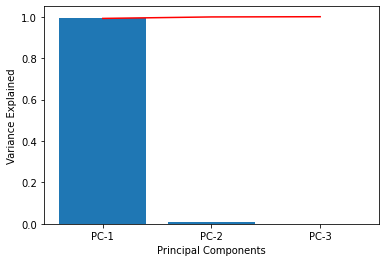

In [44]:
# Plotting:
x = []
for i in range(len(model.explainedVariance)):
    x.append('PC-' + str(i + 1))
    
y = np.array(model.explainedVariance)
z = np.cumsum(model.explainedVariance)

plt.figure()
plt.xlabel("Principal Components")
plt.ylabel("Variance Explained")
plt.bar(x, y)
plt.plot(x, z, 'r')
plt.show();

*Note: We are seeing that the first component explains 99% of variance, this is because we havent Standardized the data, and thats why we have this result.*

##### Lets Standardize the data along with assembling:

In [45]:
# function to assemble and standardize:
def scale_assemble(df, features_list, target_variable_name):
    
    assembler = VectorAssembler(inputCols=features_list, outputCol='assembler_output')
    scaler = StandardScaler(inputCol=assembler.getOutputCol(), outputCol='features2')
    
    pipeline = Pipeline(stages=[assembler, scaler])
    
    selected_cols = [target_variable_name, 'features2'] + features_list
    
    # model:
    scaled_model = pipeline.fit(df)
    df = scaled_model.transform(df).select(selected_cols)
    return df

In [46]:
# new features list:
target_variable_name = 'y'
features_list = df.columns

features_list.remove(target_variable_name)
features_list.remove('feature')

In [47]:
features_list

['age',
 'balance',
 'day',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [48]:
# applying the function to the df:
df = scale_assemble(df, features_list, target_variable_name)

In [49]:
df.printSchema()

root
 |-- y: double (nullable = false)
 |-- features2: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- balance: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- job: double (nullable = false)
 |-- marital: double (nullable = false)
 |-- education: double (nullable = false)
 |-- default: double (nullable = false)
 |-- housing: double (nullable = false)
 |-- loan: double (nullable = false)
 |-- contact: double (nullable = false)
 |-- month: double (nullable = false)
 |-- poutcome: double (nullable = false)



##### Applying PCA with standardized data:

In [50]:
pca = PCA(k=3, inputCol='features2', outputCol='pcaFeatures')

In [51]:
model = pca.fit(df)
results = model.transform(df).select('pcaFeatures')

In [52]:
results.show(truncate=False)

+------------------------------------------------------------+
|pcaFeatures                                                 |
+------------------------------------------------------------+
|[-0.4644142164927719,3.049182235189231,-3.1068609182408675] |
|[-0.4175843081487315,1.939595579401488,-1.4233873028526989] |
|[-0.5602625730593708,1.7172214203105833,-0.9990540872432135]|
|[-0.5501186775777905,3.039358938724218,-3.7635797340253134] |
|[-0.3733551759709914,4.638013436006294,-0.9957124286640747] |
|[-0.49697427374014125,1.9157932057206255,-2.281377956560747]|
|[-0.5731010183633269,1.010470440507545,-1.1454673356525147] |
|[-0.6900467931528002,2.0237713278687,0.3065703703995186]    |
|[-0.5039490659816055,3.6597285262273362,-3.204221549019425] |
|[-0.4199600530035481,1.9422704770403387,-1.4644142022269446]|
|[-0.3420077707742454,1.8275190997086868,-0.5751233281176567]|
|[-0.394188407948275,1.4706548471472922,-0.8269802108503758] |
|[-0.4279437874606594,2.470900702898163,-2.164210488593

In [53]:
# lets now look at the variance explained:

model.explainedVariance

DenseVector([0.1434, 0.0987, 0.0787])

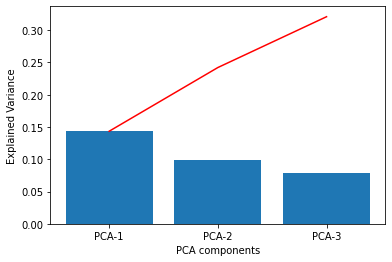

In [54]:
# Plotting the results:

x = []
for i in range(len(model.explainedVariance)):
    x.append('PCA-' + str(i + 1))
    
y = np.array(model.explainedVariance)
z = np.cumsum(model.explainedVariance)

plt.figure()
plt.xlabel('PCA components')
plt.ylabel('Explained Variance')
plt.plot(x, z, 'r')
plt.bar(x, y)
plt.show();

### Applying SVD:

In [56]:
# looking at the data:
df.printSchema()

root
 |-- y: double (nullable = false)
 |-- features2: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- balance: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- job: double (nullable = false)
 |-- marital: double (nullable = false)
 |-- education: double (nullable = false)
 |-- default: double (nullable = false)
 |-- housing: double (nullable = false)
 |-- loan: double (nullable = false)
 |-- contact: double (nullable = false)
 |-- month: double (nullable = false)
 |-- poutcome: double (nullable = false)



In [57]:
# converting df to rdd:
df_svd_vector = df.rdd.map(lambda x: x['features2'].toArray())

In [58]:
# creating the row matrix:
matrix = RowMatrix(df_svd_vector)

In [ ]:
# Computing the top 5 singular values and corresponding singular vectors:
no_singular_values = 5
svd = matrix.computeSVD(k=no_singular_values, computeU=True)

In [ ]:
# Getting the vectors and singular values:

U = svd.U  # the left singular vectors
s = svd.s  # the singular values
V = svd.V  # the right singular vectors

### Model-Based Feature Selection

In [63]:
# creating the instance of the model:
rf = RandomForestClassifier(featuresCol='features2', labelCol=target_variable_name)

In [64]:
# Fitting the data:
rf_model = rf.fit(df)

In [66]:
# Getting the features importances from the model:
rf_model.featureImportances

SparseVector(16, {0: 0.0306, 1: 0.0087, 2: 0.0028, 3: 0.356, 4: 0.0045, 5: 0.0376, 6: 0.0208, 7: 0.0029, 8: 0.0027, 9: 0.0013, 10: 0.0001, 11: 0.036, 12: 0.0013, 13: 0.0246, 14: 0.0985, 15: 0.3717})

In [80]:
# lets build the dataframe for easy access:
feat_df = features_df.drop('vals', axis=1)

In [81]:
feat_df

,idx,name
0,7,job
1,8,marital
2,9,education
3,10,default
4,11,housing
5,12,loan
6,13,contact
7,14,month
8,15,poutcome


In [82]:
rf_output = rf_model.featureImportances

In [83]:
feat_df['feature_importance'] = feat_df['idx'].apply(lambda x: rf_output[x] if x in rf_output.indices else 0)

In [84]:
# sorting the df according to the feature importance
feat_df.sort_values('feature_importance', ascending=False, inplace=True)

In [85]:
feat_df

,idx,name,feature_importance
8,15,poutcome,0.371703
7,14,month,0.098509
4,11,housing,0.035966
6,13,contact,0.024590
0,7,job,0.002947
1,8,marital,0.002655
5,12,loan,0.001332
2,9,education,0.001271
3,10,default,0.000093


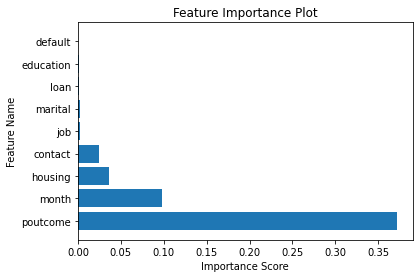

In [87]:
# plotting the data:
plt.figure()
plt.barh(feat_df['name'], feat_df['feature_importance'])
plt.title('Feature Importance Plot')
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.show();